# Paragraph Segmentation

## 1. Import important packages

In [0]:
!nvcc --version
# Install CUDA10-compatible version of mxnet
!pip install mxnet-cu100
# install Skafos python sdk
!pip install skafos

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
     |████████████████████████████████| 540.1MB 31kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [0]:
!pip install mxboard

     |████████████████████████████████| 51kB 1.7MB/s 


In [0]:
import time
import random
import os

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import mxnet as mx
import numpy as np
#from skimage.draw import line_aa
from skimage import transform as skimage_transform

from mxnet import nd, autograd, gluon
from mxnet.image import resize_short
from mxboard import SummaryWriter


from utilities.iam_dataset import IAMDataset
from utilities.draw_box_on_image import draw_box_on_image



model_checkpoint_folder = "model_checkpoint"
model_export_folder = "model_export"
if not os.path.isdir(model_checkpoint_folder):
    os.makedirs(model_checkpoint_folder)
if not os.path.isdir(model_export_folder):
    os.makedirs(model_export_folder)
    
ctx = mx.gpu() if mx.context.num_gpus() > 0 else mx.cpu()
mx.random.seed(42)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
print(ctx)

gpu(0)


## 2. Create train and test data and apply augmentation/transformation

In [0]:
train_ds = IAMDataset("form", output_data="bb", output_parse_method="form", train=True)
print("Number of training samples: {}".format(len(train_ds)))

test_ds = IAMDataset("form", output_data="bb", output_parse_method="form", train=False)
print("Number of testing samples: {}".format(len(test_ds)))

Processing data:
Convert subject list
Number of training samples: 983
Convert subject list
Number of testing samples: 232


In [0]:
batch_size = 32

random_y_translation, random_x_translation = (0.2, 0.2) # Randomly translate the input image
expand_bb_scale = 0.03 # Expand the bounding box 

In [0]:
def transform(data, label):
    '''
    Function that converts "data"" into the input image tensor for a CNN
    Label is converted into a float tensor.
    '''
    image = mx.nd.array(data).expand_dims(axis=2)
    image = resize_short(image, int(800/3))
    image = image.transpose([2, 0, 1])/255.
    label = label[0].astype(np.float32)
    #print(label)
    
    bb = label.copy()
    new_w = (1 + expand_bb_scale) * bb[2]
    new_h = (1 + expand_bb_scale) * bb[3]
    
    bb[0] = bb[0] - (new_w - bb[2])/2
    bb[1] = bb[1] - (new_h - bb[3])/2
    bb[2] = new_w
    bb[3] = new_h

    return image, mx.nd.array(bb)

def augment_transform(data, label):
    '''
    Function that randomly translates the input image by +-width_range and +-height_range.
    The labels (bounding boxes) are also translated by the same amount.
    '''
    ty = random.uniform(-random_y_translation, random_y_translation)
    tx = random.uniform(-random_x_translation, random_x_translation)
    st = skimage_transform.SimilarityTransform(translation=(tx*data.shape[1], ty*data.shape[0]))
    data = skimage_transform.warp(data, st)
    label = label.copy()
    label[0][0] = label[0][0] - tx
    label[0][1] = label[0][1] - ty
    return transform(data*255., label)

In [0]:
train_data = mx.gluon.data.DataLoader([trans for trans in train_ds.transform(augment_transform)],
                                      batch_size, shuffle=True, num_workers=0)
test_data = mx.gluon.data.DataLoader([trans for trans in test_ds.transform(transform)],
                                     batch_size, shuffle=False, num_workers=0)

## 3. Create SegmentationNetwork

In [0]:
class SegmentationNetwork(gluon.nn.HybridBlock):
    
    def __init__(self, p_dropout = 0.5):
        super(SegmentationNetwork, self).__init__()

        pretrained = gluon.model_zoo.vision.resnet34_v1(pretrained=True, ctx=ctx)
        first_weights = pretrained.features[0].weight.data().mean(axis=1).expand_dims(axis=1)
        

        body = gluon.nn.HybridSequential(prefix="SegmentationNetwork_")
        with body.name_scope():
            first_layer = gluon.nn.Conv2D(channels=64, kernel_size=(7, 7), padding=(3, 3), strides=(2, 2), in_channels=1, use_bias=False)
            first_layer.initialize(mx.init.Normal(), ctx=ctx)
            first_layer.weight.set_data(first_weights)
            body.add(first_layer)
            body.add(*pretrained.features[1:6])
        
            output = gluon.nn.HybridSequential()
            with output.name_scope():
                output.add(gluon.nn.Flatten())
                output.add(gluon.nn.Dense(64, activation='relu'))
                output.add(gluon.nn.Dropout(p_dropout))
                output.add(gluon.nn.Dense(64, activation='relu'))
                output.add(gluon.nn.Dropout(p_dropout))
                output.add(gluon.nn.Dense(4, activation='sigmoid'))

            output.collect_params().initialize(mx.init.Normal(), ctx=ctx)
            body.add(output)
        self.cnn = body

    def hybrid_forward(self, F, x):
        return self.cnn(x)

net = SegmentationNetwork()
net.hybridize()
net.collect_params().reset_ctx(ctx)

In [0]:
print_every_n = 10
send_image_every_n = 20

def run_epoch(e, network, dataloader, loss_function, trainer, log_dir, print_name, is_train):
    total_loss = nd.zeros(1, ctx)
    for i, (data, label) in enumerate(dataloader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        
        with autograd.record(train_mode=is_train):
            output = network(data)
            loss_i = loss_function(output, label)
        if is_train:
            loss_i.backward()
            trainer.step(data.shape[0])

        total_loss += loss_i.mean()
        
        if e % send_image_every_n == 0 and e > 0 and i == 0:
            output_image = draw_box_on_image(output.asnumpy(), label.asnumpy(), data.asnumpy())
    epoch_loss = float(total_loss .asscalar())/len(dataloader)
    
    with SummaryWriter(logdir=log_dir, verbose=False, flush_secs=5) as sw:
        sw.add_scalar('loss', {print_name: epoch_loss}, global_step=e)
        if e % send_image_every_n == 0 and e > 0:
            output_image[output_image<0] = 0
            output_image[output_image>1] = 1
            sw.add_image('bb_{}_image'.format(print_name), output_image, global_step=e)
            
    return epoch_loss

In [0]:
checkpoint_name = "cnn_mse.params"
best_test_loss = 10e5

In [0]:
loss_function = gluon.loss.L2Loss()
epochs = 106
best_epoch = 0
learning_rate = 0.00005
log_dir = "E:\Project\HandwrittenTextRecognition\logs"

In [0]:
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': learning_rate})

In [0]:
for X_batch, y_batch in train_data:
    print("X_batch has shape {}, and y_batch has shape {}".format(X_batch.shape, y_batch.shape))

X_batch has shape (32, 1, 372, 266), and y_batch has shape (32, 4)
X_batch has shape (32, 1, 372, 266), and y_batch has shape (32, 4)
X_batch has shape (32, 1, 372, 266), and y_batch has shape (32, 4)
X_batch has shape (32, 1, 372, 266), and y_batch has shape (32, 4)
X_batch has shape (32, 1, 372, 266), and y_batch has shape (32, 4)
X_batch has shape (32, 1, 372, 266), and y_batch has shape (32, 4)
X_batch has shape (32, 1, 372, 266), and y_batch has shape (32, 4)
X_batch has shape (32, 1, 372, 266), and y_batch has shape (32, 4)
X_batch has shape (32, 1, 372, 266), and y_batch has shape (32, 4)
X_batch has shape (32, 1, 372, 266), and y_batch has shape (32, 4)
X_batch has shape (32, 1, 372, 266), and y_batch has shape (32, 4)
X_batch has shape (32, 1, 372, 266), and y_batch has shape (32, 4)
X_batch has shape (32, 1, 372, 266), and y_batch has shape (32, 4)
X_batch has shape (32, 1, 372, 266), and y_batch has shape (32, 4)
X_batch has shape (32, 1, 372, 266), and y_batch has shape (32

## 4. Train model

In [0]:
print("Before for loop, number of epochs is ",epochs)
for e in range(epochs):
    print("epoch")
    train_loss = run_epoch(e, net, train_data, loss_function=loss_function, log_dir=log_dir, 
                           trainer=trainer, print_name="train", is_train=True)
    print("Train done")
    test_loss = run_epoch(e, net, test_data, loss_function=loss_function, log_dir=log_dir,
                          trainer=trainer, print_name="test", is_train=False)
    print("Test done")
    if test_loss < best_test_loss:
        print("Saving network, previous best test loss {:.6f}, current test loss {:.6f}".format(best_test_loss, test_loss))
        net.save_parameters(os.path.join(model_checkpoint_folder, checkpoint_name))
        best_epoch = e
        best_test_loss = test_loss
    if e % print_every_n == 0 and e > 0:
        print("Epoch {0}, train_loss {1:.6f}, test_loss {2:.6f}".format(e, train_loss, test_loss))

Before for loop, number of epochs is  106
epoch
Train done
Test done
Saving network, previous best test loss 1000000.000000, current test loss 0.006091
epoch
Train done
Test done
Saving network, previous best test loss 0.006091, current test loss 0.001459
epoch
Train done
Test done
epoch
Train done
Test done
epoch
Train done
Test done
Saving network, previous best test loss 0.001459, current test loss 0.001433
epoch
Train done
Test done
epoch
Train done
Test done
epoch
Train done
Test done
Saving network, previous best test loss 0.001433, current test loss 0.001338
epoch
Train done
Test done
Saving network, previous best test loss 0.001338, current test loss 0.001306
epoch
Train done
Test done
Saving network, previous best test loss 0.001306, current test loss 0.001247
epoch
Train done
Test done
Saving network, previous best test loss 0.001247, current test loss 0.001218
Epoch 10, train_loss 0.004101, test_loss 0.001218
epoch
Train done
Test done
Saving network, previous best test loss

In [0]:
print(best_epoch)

94


In [0]:
net.export("model_export/cnn_mse", epoch=best_epoch)

## 5. Test model

In [0]:
#If model trained previously:
sym = mx.sym.load_json(open('/content/drive/My Drive/image_processing/cnn_mse-symbol.json', 'r').read())
net = gluon.nn.SymbolBlock(outputs=sym, inputs=mx.sym.var('data'))
net.load_parameters('/content/drive/My Drive/image_processing/cnn_mse-0094.params', ctx=ctx)

FileNotFoundError: ignored

[✔ CUDA, ✔ CUDNN, ✔ NCCL, ✔ CUDA_RTC, ✖ TENSORRT, ✔ CPU_SSE, ✔ CPU_SSE2, ✔ CPU_SSE3, ✔ CPU_SSE4_1, ✔ CPU_SSE4_2, ✖ CPU_SSE4A, ✔ CPU_AVX, ✖ CPU_AVX2, ✖ OPENMP, ✖ SSE, ✔ F16C, ✖ JEMALLOC, ✖ BLAS_OPEN, ✖ BLAS_ATLAS, ✖ BLAS_MKL, ✖ BLAS_APPLE, ✔ LAPACK, ✖ MKLDNN, ✔ OPENCV, ✖ CAFFE, ✖ PROFILER, ✔ DIST_KVSTORE, ✖ CXX14, ✖ INT64_TENSOR_SIZE, ✔ SIGNAL_HANDLER, ✖ DEBUG]
[✔ CUDA, ✔ CUDNN, ✔ NCCL, ✔ CUDA_RTC, ✖ TENSORRT, ✔ CPU_SSE, ✔ CPU_SSE2, ✔ CPU_SSE3, ✔ CPU_SSE4_1, ✔ CPU_SSE4_2, ✖ CPU_SSE4A, ✔ CPU_AVX, ✖ CPU_AVX2, ✖ OPENMP, ✖ SSE, ✔ F16C, ✖ JEMALLOC, ✖ BLAS_OPEN, ✖ BLAS_ATLAS, ✖ BLAS_MKL, ✖ BLAS_APPLE, ✔ LAPACK, ✖ MKLDNN, ✔ OPENCV, ✖ CAFFE, ✖ PROFILER, ✔ DIST_KVSTORE, ✖ CXX14, ✖ INT64_TENSOR_SIZE, ✔ SIGNAL_HANDLER, ✖ DEBUG]
[✔ CUDA, ✔ CUDNN, ✔ NCCL, ✔ CUDA_RTC, ✖ TENSORRT, ✔ CPU_SSE, ✔ CPU_SSE2, ✔ CPU_SSE3, ✔ CPU_SSE4_1, ✔ CPU_SSE4_2, ✖ CPU_SSE4A, ✔ CPU_AVX, ✖ CPU_AVX2, ✖ OPENMP, ✖ SSE, ✔ F16C, ✖ JEMALLOC, ✖ BLAS_OPEN, ✖ BLAS_ATLAS, ✖ BLAS_MKL, ✖ BLAS_APPLE, ✔ LAPACK, ✖ MKLDNN, ✔ OPENCV, ✖ CAF

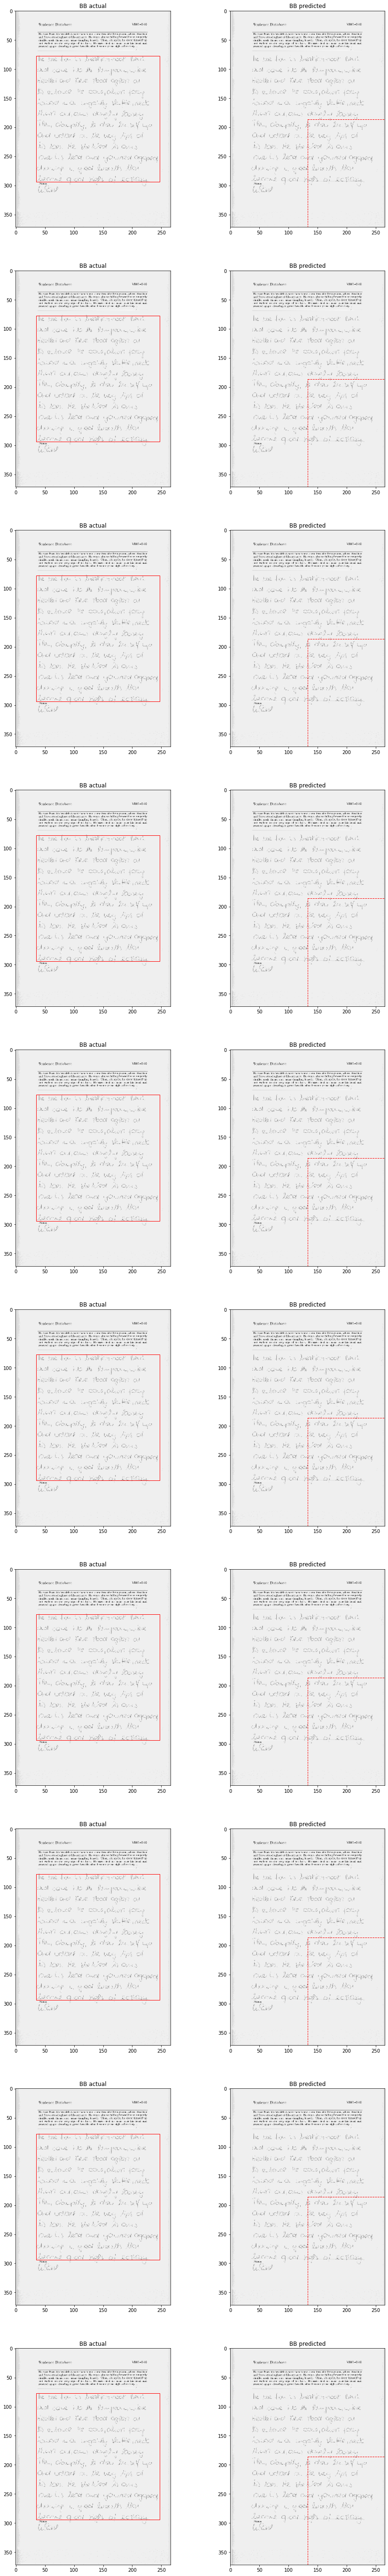

In [0]:
from mxnet.runtime import feature_list
figs_to_plot = 10
fig, axs = plt.subplots(figs_to_plot, 2, figsize=(15,10* figs_to_plot))

for i in range(figs_to_plot):
    #n = int(random.random()*len(test_ds))
    image, bb = test_ds[0]

    image, _ = transform(image, bb)
    image = image.as_in_context(ctx)
    image = image.expand_dims(axis=0)
    bb_predicted = net(image)

    (x, y, w, h) = bb[0]
    axs[i][0].imshow(image.asnumpy().squeeze(), cmap='Greys_r')
    image_h, image_w = image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
    axs[i][0].add_patch(rect)
    axs[i][0].set_title("BB actual")

    axs[i][1].imshow(image.asnumpy().squeeze(), cmap='Greys_r')
    (x, y, w, h) = bb_predicted[0].asnumpy()
    image_h, image_w = image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r", ls="--")
    axs[i][1].add_patch(rect)
    axs[i][1].set_title("BB predicted")
    print(feature_list())